In [1]:
import time
import copy
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns

from operator import truediv

import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.rcParams['savefig.dpi'] = 150
plt.rcParams.update({'figure.autolayout': True})

from sklearn.metrics import accuracy_score

from tqdm.autonotebook import tqdm

#Pytorch
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, models, datasets

#Google Mount
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My\ Drive/Classes/Covid_19_project/

#Utilities
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Classes/Covid_19_project


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(42)

In [3]:
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'


dirs = {'test': test_dir,
        'train': train_dir, 
        'val': val_dir, 
       }

In [4]:
# add transforms to the data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [5]:
batch_size = 2

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'val', 'test']}

# load the data into batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'val', 'test']}

In [25]:
# ResNet50 model

resnet50_model = models.resnet50(pretrained=True)

num_features = resnet50_model.fc.in_features
# change the outputs from 512 to 2
resnet50_model.fc = nn.Linear(num_features, 2)

#unfreezing your model (for better accuracy)
for param in resnet50_model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [7]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

In [8]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [9]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None, score_funcs=None, 
                  epochs=50, device="cpu", checkpoint_file=None, 
                  lr_schedule=None, optimizer=None, disable_tqdm=False):
  
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    optimizer -- the method used to alter the gradients for learning. 
    """

    if score_funcs == None:
        score_funcs = {} #Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}

    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)


In [10]:
#Confusion matrix function

def confusion_matrix(nb_classes, loader, model):
  confusion_matrix = np.zeros((nb_classes, nb_classes))

  with torch.no_grad():
    for i, (inputs, classes) in enumerate(loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

  return confusion_matrix

In [11]:
# DF for best epochs collection and visualization
best_epoch_df = pd.DataFrame() 

# DF for Precision and Recall collection and visualization
precision_recall_df = pd.DataFrame(columns = ['Model', 'Precision 0', 'Precision 1', 'Recall 0', 'Recall 1'])

In [12]:
# Parameters of the network
epochs = 30
lr = 0.01

In [13]:
loss = nn.CrossEntropyLoss()

In [14]:
resnet50_results = train_network(resnet50_model, loss, dataloaders['train'], val_loader = dataloaders['val'],
                        epochs = epochs, optimizer = torch.optim.SGD(resnet50_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/resnet50-activ.pth', score_funcs = {'Accuracy': accuracy_score}, device = device)

In [15]:
loss = nn.MultiMarginLoss() #Creates a criterion that optimizes a multi-class classification hinge loss (margin-based loss) 

In [16]:
resnet50_svm = train_network(resnet50_model, loss, dataloaders['train'], val_loader = dataloaders['val'],
                        epochs = epochs, optimizer = torch.optim.SGD(resnet50_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/resnetsvm-activ.pth', score_funcs = {'Accuracy': accuracy_score}, device = device)

In [17]:
resnet50_results = resnet50_results.assign(Model='Resnet50')
resnet50_svm = resnet50_svm.assign(Model='Resnet50-SVM')

best_epoch_df = best_epoch_df.append(resnet50_results.loc[resnet50_results['val Accuracy'].idxmax()])
best_epoch_df = best_epoch_df.append(resnet50_svm.loc[resnet50_svm['val Accuracy'].idxmax()])

In [18]:
best_epoch_df

,Model,epoch,total time,train Accuracy,train loss,val Accuracy,val loss
4,Resnet50,4.0,182.697149,0.804187,0.458831,0.989362,0.134703
12,Resnet50-SVM,12.0,471.041097,0.975369,0.028565,1.000000,0.010870


In [19]:
precision_recall_df

,Model,Precision 0,Precision 1,Recall 0,Recall 1


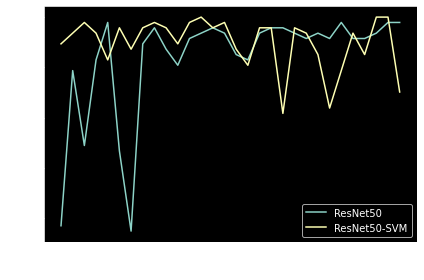

In [23]:
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = resnet50_results, label = 'ResNet50');
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = resnet50_svm, label = 'ResNet50-SVM');
plt.savefig('images/training_30epochs-active.png');

## SVM activation function

The only difference between a (linear) logistic regression and a (linear) SVM is the loss function. If we replace cross entropy loss with the Hinge loss (torch.nn.HingeEmbeddingLoss), we get a SVM activation.

